Australian Political Party Donations: 2013-2014
===

__Overview__

A number of inidividuals and organisations have made numerous donations to political parties in Australia. This sheet doesn't seek to find the motive behind these donations but it does seek to summarise *who* is donating to which parties.

__Source of Data__

All the data in this Notebook comes from the Australian Electoral Commission Website. You can do your own research by looking [here](http://periodicdisclosures.aec.gov.au/).


In [2]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import math
from IPython.display import display, HTML
import urllib
import itertools as itt
pd.options.display.float_format = '${:,.0f}'.format
pd.set_option('max_colwidth', 1000, 'max_rows', 100)
%matplotlib inline

__Data Loading__

Load data from the csvs downloaded off the AEC website.

In [27]:
labor = pd.read_csv('data/labor-2013-2014.csv')
liberal = pd.read_csv('data/liberal-2013-2014.csv')
national = pd.read_csv('data/national-2013-2014.csv')
green = pd.read_csv('data/green-2013-2014.csv')
donations = {
    'Labor' : labor,
    'Liberal' : liberal,
    'Nationals' : national,
    'Greens' : green
}

__Donation Totals__

Total value of donations over the reportable ($12,400) threadhold in 2013-2014



,Total Donated
Labor,"$8,316,715"
Nationals,"$1,063,971"
Liberal,"$16,730,155"
Greens,"$1,709,849"


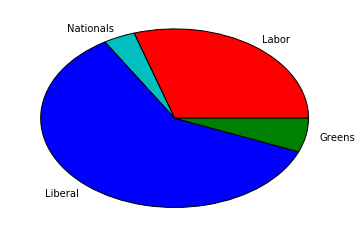

In [31]:
print('Total value of donations over the reportable ($12,400) threadhold in 2013-2014')
print('')
totals = list(map(lambda v: v['AmountPaid'].sum(), donations.values()))
display(pd.DataFrame(totals, donations.keys(), columns=['Total Donated']))    
ax = plt.pie(totals, labels=list(donations.keys()), colors=('r', 'c', 'b', 'g'))

__Distribution of Donation Sizes__

This helps us get an idea about the size of donations to each party. In 2013-2015 the Labor party had the largest donation ($850K).

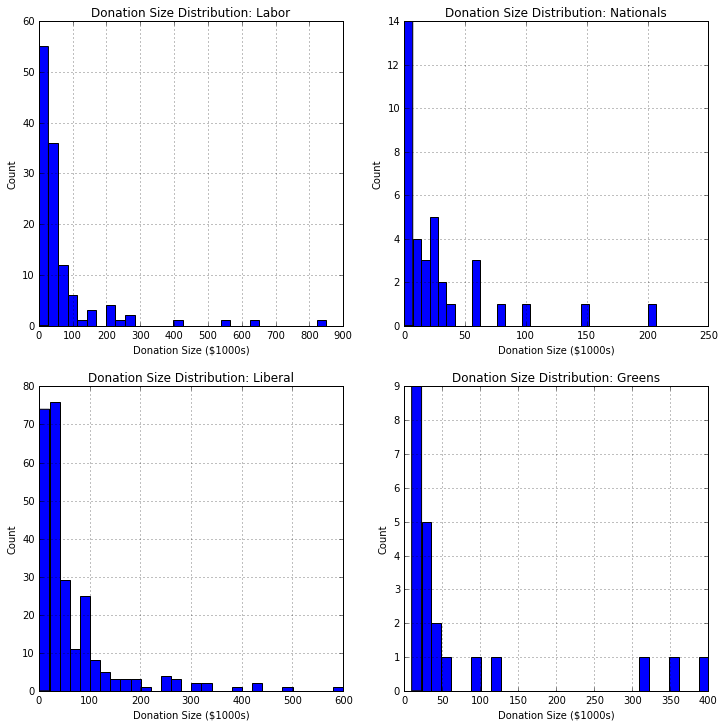

In [20]:
f, axarr = plt.subplots(2, 2)
i = 0
for party, dons in donations.items():
    ax = axarr[int(i / 2), i % 2]
    ax = (dons.groupby('DonorClientNm').sum()['AmountPaid'] / 1000).hist(bins=30, ax = ax)
    ax.set_xlabel('Donation Size ($1000s)')
    ax.set_ylabel('Count')
    ax.set_title('Donation Size Distribution: %s' % party)
    i += 1
fig = plt.gcf().set_size_inches(12, 12)    

__Cumulative Distributions of Donations__

This also helps us understand the size of donations that each party recieved. We additionally add some lines to these charts to help show what 50% of the donations represents, and how many donors make up 50% of the total value of donations.

It's also worth noting that the more *curved* this chart is, the more *unequal* the size of the donations are. If everyone donated the same amount we would expect the green line to be half way along the chart and for the blue line to be a straight line. What this shows is that for some political parties a reasonably small percentage of donors account for 50% of the total value of donations. Further down this sheet, we'll dig into who these donors are.

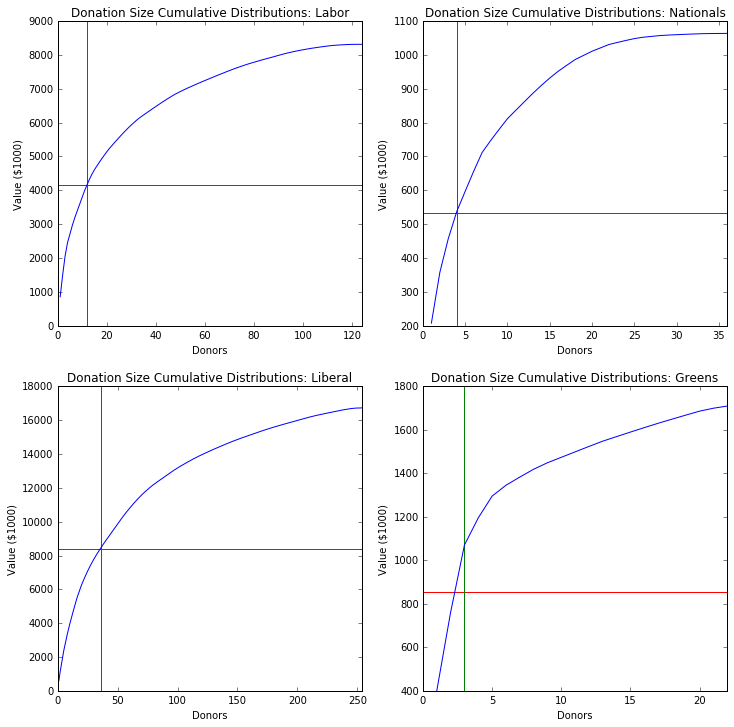

In [21]:
f, axarr = plt.subplots(2, 2)
i = 0
for party, dons in donations.items():
    ax = axarr[int(i / 2), i % 2]
    sums = dons.groupby('DonorClientNm').sum()['AmountPaid']
    sums = sums.sort_values(ascending=False) / 1000
    sums.index = range(1, len(sums) + 1)
    cumsums = sums.cumsum()
    total = sums.sum()
    half = total / 2
    half_idx = cumsums[cumsums < half].index[-1]
    ax.axhline(half, color='r')
    ax.axvline(half_idx + 1, color='g')
    cumsums.plot(ax=ax)
    ax.set_title('Donation Size Cumulative Distributions: %s' % party)
    ax.set_xlabel('Donors')
    ax.set_ylabel('Value ($1000)')
    i += 1
fig = plt.gcf().set_size_inches(12, 12) 

__Big Donors__

We'd like to have a look at who are the biggest donors to each of the parties. For this we'll look the largest donors who cumulatively account for 50% of the total value of donations to each party.

In [22]:
def gurl(n):
    data = {'q' : n}
    url = 'https://www.google.com/search?%s' % urllib.parse.urlencode(data)
    return url
    
for party, dons in donations.items():
    sums = dons.groupby('DonorClientNm').sum()
    sums = pd.DataFrame(sums.sort_values(by='AmountPaid', ascending=False)['AmountPaid'])
    sums['cumsum'] = sums.cumsum()
    total = sums['AmountPaid'].sum()
    sums = sums[sums['cumsum'] < total / 2]
    del sums['cumsum']
    sums = sums.reset_index()
    sums['Google Search'] = sums.apply(lambda r: '<a href=\"%s\">Search</a>' % gurl(r['DonorClientNm']), axis=1)
    display(HTML('<h2> %s </h2>' % party))
    display(HTML(sums.to_html(escape=False)))

,DonorClientNm,AmountPaid,Google Search
0,Zi Chun WANG,"$850,000",Search
1,AUSTRALIA KINGOLD INVESTMENT DEVELOPMENT CO. PTY. LTD.,"$635,000",Search
2,CFMEU National Office,"$566,000",Search
3,Mr JINGUI XU,"$400,000",Search
4,Yuhu Group (Australia) Pty Ltd,"$260,000",Search
5,Australia Chinese Business Elite Awards Pty Ltd,"$260,000",Search
6,Village Roadshow Limited,"$227,500",Search
7,Mr Lawrence Kung,"$200,000",Search
8,Wei Wah International Trading Pty Ltd,"$200,000",Search
9,Sunpac Resources Pty Ltd,"$200,000",Search


,DonorClientNm,AmountPaid,Google Search
0,Manildra Group,"$207,206",Search
1,Dr Geoffrey Handbury,"$150,000",Search
2,Hong Kong Kingson Investments,"$100,000",Search


,DonorClientNm,AmountPaid,Google Search
0,Paul Ramsay Holdings Pty Limited,"$600,000",Search
1,Nimrod Resources Limited,"$500,000",Search
2,P. Marks Investment Pty Ltd,"$431,361",Search
3,Yuhu Group (Australia) Pty Ltd,"$425,000",Search
4,Balmoral Pastoral Pty Ltd,"$400,000",Search
5,Hong Kong Kingson Investments,"$340,000",Search
6,Village Roadshow Limited,"$329,919",Search
7,Australian Southern Bluefin Tuna (SBT) Industry Association Ltd,"$320,000",Search
8,D F and H G Stahmann,"$305,000",Search
9,Macquarie Group Limited,"$277,630",Search


,DonorClientNm,AmountPaid,Google Search
0,Ms Anna Milanowicz,"$400,000",Search
1,Electrical Trades Union,"$360,766",Search


__Multiple Donations__

Some donors donate to multiple political parties. Here's a list of these donors.

In [23]:
donors = {}
for party, dons in donations.items():
    donors[party] = set(dons['DonorClientNm'])
multi_donors = set()
for comb in itt.product(donors.keys(),donors.keys()):
    if comb[0] != comb[1]:
        multi_donors = multi_donors.union(donors[comb[0]].intersection(donors[comb[1]]))    

In [24]:
table = []
for donor in multi_donors:
    row = {'Donor' : donor}
    for party, dons in donations.items():
        row[party] = dons[dons['DonorClientNm'] == donor]['AmountPaid'].sum()
    table.append(row)
multi_donor_df = pd.DataFrame(table)
multi_donor_df['Google Search'] = multi_donor_df.apply(
    lambda r: '<a href=\"%s\">Search</a>' % gurl(r['Donor']), axis=1)


print('Number of entities dontating above the reportable threshold' 
      + ' ($12,800) to multiple parties: %d' % len(multi_donors))

display(HTML(multi_donor_df.to_html(escape=False)))

Number of entities dontating above the reportable threshold ($12,800) to multiple parties: 97


,Donor,Greens,Labor,Liberal,Nationals,Google Search
0,Retail Guild of Australia Inc,$0,$0,"$26,500","$55,577",Search
1,New South Wales Minerals Council Ltd,$0,"$5,000","$31,000","$12,250",Search
2,NATIONAL ROADS & MOTORISTS' ASSOCIATION LIMITED,$0,"$30,795","$24,300","$2,500",Search
3,AUSTRALIA KINGOLD INVESTMENT DEVELOPMENT CO. PTY. LTD.,$0,"$635,000","$200,000",$0,Search
4,Technology One Limited,$0,"$1,000","$31,225",$0,Search
5,Allianz Australia Ltd,$0,"$49,450","$93,870",$0,Search
6,Macquarie Telecom Pty Ltd,"$25,000","$48,500","$49,500",$0,Search
7,Ms Mary Stuart,"$20,000",$500,$0,$0,Search
8,Fossano Pty Ltd,$0,"$10,000","$15,000",$0,Search
9,Financial Services Council Limited,$0,"$82,316","$82,179",$0,Search


__Largest Recipients__

In instances where a donor donated to multiple political parties, which parties got the most money? We look at this in two ways; the sum of all donations to a party from a multi-donor, and the number of instances where a party was the largest recipient. These two measures while similar, are slightly different and the latter is less suseptible to influence from a small number of large donors.


In [25]:
def largest_recipient(row):
    mx = max([k for k in row if type(k) is float])
    largest = ''
    largest_key = [key for key, value in row.items() if value == mx][0]
    return largest_key

multi_donor_df['Largest'] = multi_donor_df.apply(largest_recipient, axis=1)
largest_recipients = {}
for party in donations.keys():
    largest_recipients[party] = len(multi_donor_df[multi_donor_df['Largest'] == party])
largest_recipients = pd.DataFrame(list(largest_recipients.values()), 
                                  list(largest_recipients.keys()), 
                                  columns=['Instances where the party was the largest recipient'])
multi_party_sums = pd.DataFrame(multi_donor_df[list(donations.keys())].sum(), 
                                columns=['Total donated from donors to multiple parties'])    

In [26]:
display(multi_party_sums)
display(largest_recipients)

,Total donated from donors to multiple parties
Labor,"$3,819,455"
Nationals,"$1,022,506"
Liberal,"$7,454,975"
Greens,"$540,766"


,Instances where the party was the largest recipient
Labor,17
Greens,3
Nationals,4
Liberal,73
